# **Lezione 3**

##### **Introduzione**

Un'opzione europea è un contratto finanziario che conferisce al compratore il diritto di acquistare (opzione call) o vendere (opzione put) un'attività (come azioni, valute, indici, ecc.) a un prezzo prefissato (detto strike price), esclusivamente alla data di scadenza del contratto (expiration date). Per ottenere questo diritto, l’acquirente paga un premio al venditore (detto anche writer dell’opzione).

Il valore di questa opzione finanziaria può essere calcolato in modo teorico attraverso il modello di Black-Scholes. Questo modello si basa sull'ipotesi che il prezzo segua un processo stocastico ben preciso: il moto browniano geometrico (GMB), caratterizzato da un tasso di interesse privo di rischio $r$ e da una volatilità costante $\sigma$.

Nel caso delle opzioni europee Balck-Scholes fornisce formule analitiche per calcolare il prezzo al tempo $t$, sia per la call che per la put: 

<div style="width: 50%; float: left;">

+ call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$

+ put-option price: 
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$
</div>
<div style="width: 50%; float: right;">

$$
\begin{cases}
 d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]\\
 d_2 = d_1 - \sigma\sqrt{T-t} \\
 N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]\\
 S(0)=100,\ \ \ T=1,\ \ \ K=100,\ \ \ r=0.1, \ \ \ \sigma=0.25 \\
\end{cases}
$$
</div>
<div style="clear: both;"></div>

Lo scopo di questo esercizio è calcolare, attraverso simulazioni Monte Carlo, il prezzo di un’opzione call e di una put europea al tempo iniziale $t=0$, utilizzando due approcci distinti:

1. Metodo diretto, simulando direttamente il valore del prezzo alla scadenza $S(T)$, sfruttando la distribuzione nota del moto browniano geometrico.
2. Metodo discretizzato, simulando l'intera traiettoria del prezzo suddividendo l'intervallo temporale $[0,T]$ in piccoli intervalli.


##### **Applicazione**

Grazie a metodi Monte Carlo basati sul modello di moto browniano geometrico, è possibile descrivere l'evoluzione del prezzo di un asset secondo la relazione:
$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$
dove $r$ è il tasso d'interesse privo di rischio, $\sigma$ è la volatilità, $W(t)∼N(0,t)$ è un moto browniano standard.

A partire dal prezzo finale simulato $S(T)$, il payoff viene calcolato:
* per la call $$ C=e^{-rT}\max(S(T)-K,0)$$
* per la put $$ P=e^{-rT}\max(K-S(T),0)$$

Nel codice, queste formule sono applicate sia nel caso diretto che in quello discretizzato in questo modo:

1. Per il metodo diretto è abbastanza semplice, sfruttando il fatto ceh $S(T)$ è distribuito log-normalmente, ossia che $\ln(S(T))$ è distribuito in maniera gaussiana, possiamo calcolare contemporaneamente $S(T), C(T,0), P(T,0) :$
```cpp
        double Z = rnd.Gauss(0, 1);
        double S = S0*exp((r-pow(sigma,2)/2)*T+sigma*Z*sqrt(T));
        C += exp(-r*T)*max(0.0, S-K);
        P += exp(-r*T)*max(0.0, K-S);
```

2. Nel metodo discretizzato, invece, si simula l’intera traiettoria $ S(0) \rightarrow S(t_1) \rightarrow ... \rightarrow S(T) $, suddividendo l'intervallo di tempo $[0,T]$ in $N_{step}=100$ sottointervalli dove applichiamo ricorsivamente il calcolo di $S(t_{i+1}):$
``` cpp
        S=S0;
        for(int k=0; k<intervalli; k++){
            double Z=rnd.Gauss(0, 1);
            S *= exp((r-pow(sigma,2)/2)*t+sigma*Z*sqrt(t));
        }
        C += exp(-r*T)*max(0.0, S-K);
        P += exp(-r*T)*max(0.0, K-S);
```
Per stimare le medie e le incertezze statistiche si divide il totale delle $M=10^5$ simulazioni in $N=100$ blocchi da $L=10^3$ lanci ciascuno. Per ogni blocco si calcola il valore medio del payoff, e successivamente si costruiscono le medie progressive e i relativi errori statistici secondo la tecnica del data blocking.

##### **Risultati**
Seguono i grafici dell'andamento nei blocchi del valor medio di $C(T,0)\ e\ P(T,0)$, sia per il metodo diretto, che per quello discretizzato. All'interno di entrambi i grafici è presente anche il valore di confronto sia per call che per put, calcolato analiticamente con il  modello di Black-Scholes. Come è facile osservare, tutte le stime risultano essere confrontabili con i valori aspettati.

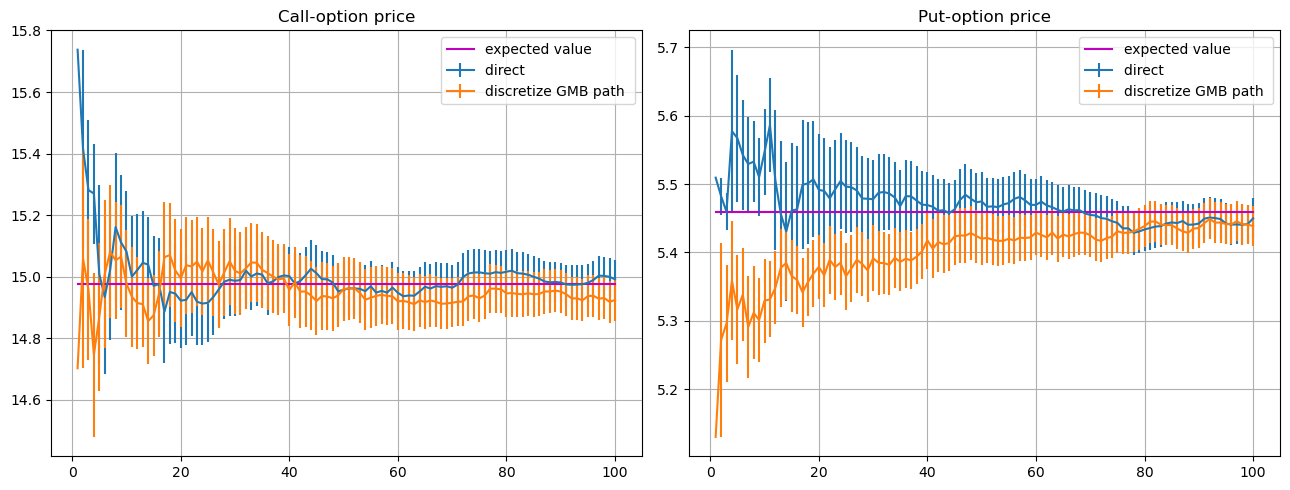

In [6]:
import matplotlib.pyplot as plt
import numpy as np

blocchi=100
C_exp=14.975790778311286
P_exp=5.4595325819072364

x = np.arange(blocchi)+1
t = np.full_like(x, C_exp, dtype=float) # Valore costante per tutte le x
w = np.full_like(x, P_exp, dtype=float) #Si, potevo fare dato-exp nel grafico (forse meglio), ma volevo provare 'sta funzione

C1, err_C1, P1, err_P1 = np.loadtxt("Files/diretto.dat", usecols=(0, 1, 2, 3), delimiter='\t', unpack='True')
C2, err_C2, P2, err_P2 = np.loadtxt("Files/discretizzato.dat", usecols=(0, 1, 2, 3), delimiter='\t', unpack='True')

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].errorbar(x, C1, yerr=err_C1, label="direct ")
axes[0].errorbar(x, C2, yerr=err_C2, label="discretize GMB path ")
axes[0].plot(x, t, '-m', label="expected value", linewidth=1.5)
axes[0].set_title("Call-option price")
axes[0].legend()
axes[0].grid(True)

axes[1].errorbar(x, P1, yerr=err_P1, label="direct ")
axes[1].errorbar(x, P2, yerr=err_P2, label="discretize GMB path ")
axes[1].plot(x, w, color='m', label="expected value", linewidth=1.5)
axes[1].set_title("Put-option price")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()